# Projet de classification multi-classes avec classes déséquilibrées (Multi-class classification with unbalanced class) 

### Projet réalisé en avril 2022. Ce notebook fait office de rapport pour un projet de prédiction sur la réussite ou l'échec d'un élève à l'université portugaise. Le but est de maximiser le score F1 pondéré. Pour cela on effectue un processus complet du nettoyage des données à l'optimisation des modèles. On utilise la littérature dans le domaine de classification avec des avec classes déséquilibrées (SMOTE..).

### Pour sélectionner des features, on utilisera l'importance des variables dans une RandomForest (Permutation), pour le choix des modèles on utilise le score F1 ( sur le test et l'apprentissage), la matrice de confusion et les courbes ROC-AUC.

### Ce projet faisait partie d'une compétition Kaggle ou l'on devait obtenir le meilleur score F1 pondéré sur le fichier test.csv. Ce notebook est arrivé 3/100.

#### On installe le package rfpimp qui n'est pas présent directement sur la machine virtuelle de Kaggle.

In [ ]:
pip install rfpimp 

  Preparing metadata (setup.py) ... - done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10669 sha256=bb9dc1d5a1a9750400321fc1c4ac95a0f0fd3990ad57ddfede32aeef4a272491
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp
Note: you may need to restart the kernel to use updated packages.


## 1) Importation Packages et Fonctions pour évaluer les modèles

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings("ignore")

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import  make_classification

from sklearn.multiclass import OneVsRestClassifier
import scipy as sc
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def score_f1(y,y_pred):#Fonction qui renvoie le score F_1 par classe puis le score F_1 global en fonction du poids des classes
    f_1=f1_score(y,y_pred,average=None)
    f_1=np.round(f_1,3)
    
    print("Le score F_1 pour la classe Dropout est de ",f_1[0])
    print("Le score F_1 pour la classe Enrolled est de ",f_1[1])
    print("Le score F_1 pour la classe Graduate est de ",f_1[2])
    
    print()
    f_1_glob=np.round(f1_score(y,y_pred,average='weighted'),3)
    print("Le score F_1 global (en prenant en compte la taille des classes) est de ",f_1_glob)
    return

def matrice_conf(y,y_pred): #Fonction qui affiche la matrice de confusion
    print()
    print("La matrice de confusion : ")
    print()
    cf=metrics.confusion_matrix(y,y_pred)
    sns.heatmap(cf,annot=True,cmap='Greens',fmt='g')
    return

def sur_apprentissage(y,model,train): #Fonction pour mesurer l'apprentissage d'un modèle (overfitting par exemple)
    print()
    print("Apprentissage sur l'ensemble train : ")
    pred=model.predict(train)
    f_1=f1_score(y,pred,average=None)
    f_1=np.round(f_1,2)
    print("Score F_1 par classe sur l'ensemble d'apprentissage : ",f_1)
    
    f_1_glob=np.round(f1_score(y,pred,average='weighted'),2)
    print("Le score F_1 global sur l'ensemble d'apprentissage :",f_1_glob)

    
def plot_multiclass_roc(clf, X_test, y_test, n_classes,X_train,y_train): #Fonction trouvé sur internet 
    #affiche les courbes roc-auc pour chaque classe
    #Tres intéressant pour calculer l'apprentissage de chaque classe pour un modèle

    clf=OneVsRestClassifier(clf)
    clf.fit(X_train,y_train)
    y_score = clf.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC-AUC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    return

## 2) Importation des données et premières visualisations

In [ ]:
data_train=pd.read_csv("../input/studentgraduation/train.csv")
data_train.head()

,StudentId,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,51,1,33,1,1,130.0,1,19,...,5,10,11,5,11.000000,0,11.1,0.6,2.02,Dropout
1,2,4,43,1,9238,1,1,120.0,1,37,...,0,6,8,4,13.750000,0,13.9,-0.3,0.79,Graduate
2,3,1,1,1,9130,1,1,140.0,1,4,...,0,6,9,6,14.857143,0,11.1,0.6,2.02,Graduate
3,4,1,17,2,9147,1,1,118.0,1,19,...,0,5,8,3,10.000000,0,11.1,0.6,2.02,Enrolled
4,5,1,53,1,9085,1,42,140.0,1,1,...,4,9,13,7,14.285714,0,8.9,1.4,3.51,Graduate


In [ ]:
data_train.drop("StudentId",axis=1,inplace=True)
data_train.shape

(3096, 37)

#### On a un jeu de données avec 3096 observations et 37 colonnes (on la colonne enlève studendId).

In [ ]:
data_train.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

#### Pas de données manquantes.

In [ ]:
data_train.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,...,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000
mean,1.182494,18.661822,1.710271,8873.215116,0.881460,4.363049,132.347933,1.904716,19.559755,22.451227,...,0.137597,0.543605,6.213178,8.003876,4.450581,10.247850,0.152778,11.523934,1.250291,0.018634
std,0.609534,17.534724,1.295090,2036.120839,0.323299,9.932176,13.006996,7.164598,15.606851,15.357628,...,0.686680,1.889698,2.154853,3.834962,2.995659,5.204218,0.738670,2.654136,1.393145,2.260256
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,124.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.800000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.000000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.250000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.000000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,184.400000,109.000000,43.000000,44.000000,...,12.000000,18.000000,23.000000,28.000000,20.000000,18.571429,8.000000,16.200000,3.700000,3.510000


#### Grâce à l'énoncé et à la fonctions describe on remarque que des variables sont catégorielles, certaines binaires et d'autres continues. Les variables continues ont des echelles différentes on peut les standardiser, on observe aussi des variables catégorielles que l'on peut encoder à l'aide du OneHotEncoding par exemple.

#### On s'intéresse maintenant à la variable Target (notre label à prédire). On commence par encoder Target avec un LabelEncoder puis on regarde la répartition des classes.

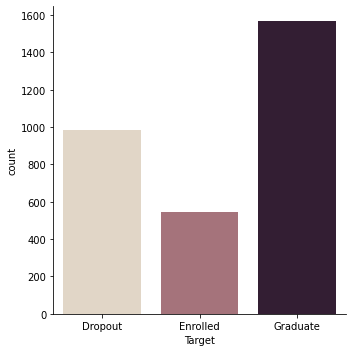

In [ ]:
data_train["Target"]= data_train["Target"].astype('category')
data_train["Target"] = data_train["Target"].cat.codes

plt2=sns.catplot(x="Target", kind="count", palette="ch:.25", data=data_train,legend_out=True)
plt2.set_xticklabels(["Dropout","Enrolled","Graduate"])

#### On remarque les classes Dropout et notamment Enrolled sont sous représentées par rapport à la classe graduate. Cela peut poser des problèmes pour l'apprentissages de ses deux sous-classes. De plus, les variables Dropout / Enrolled sont les classes que l'on veut essentiellement prédire (en effet on veut etre capable de prédire l'echec / echec partiel pour comprendre ses raisons).

## 3) Features Engineering

#### On veut connaitre les variables qui ont le plus d'importance pour la prédiction des classes. Pour cela on va regarder les features importances à l'aide d'une RandomForest. On commence par diviser notre dataset en deux, un jeu pour l'apprentissage et un autre pour la validation. On prend 20% pour la validation car on à peu de données.

#### On standardise les données pour aider à l'apprentissage.

In [ ]:
from sklearn.model_selection import train_test_split

X=data_train.drop("Target",axis=1)
y=data_train.Target

from sklearn.preprocessing import StandardScaler
X[X.columns]=StandardScaler().fit_transform(X)

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.20)

#### On regarde la répartition des classes pour les deux ensembles de données.

In [ ]:
y_train.value_counts(normalize=True)

2    0.514540
0    0.312601
1    0.172859
Name: Target, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

2    0.474194
0    0.335484
1    0.190323
Name: Target, dtype: float64

#### On obtient une répartition similaire entre les deux jeux de données.

#### Maintenant on regarde l'importance des variables en utilisant l'attribut d'une random forest et la méthode permutation.

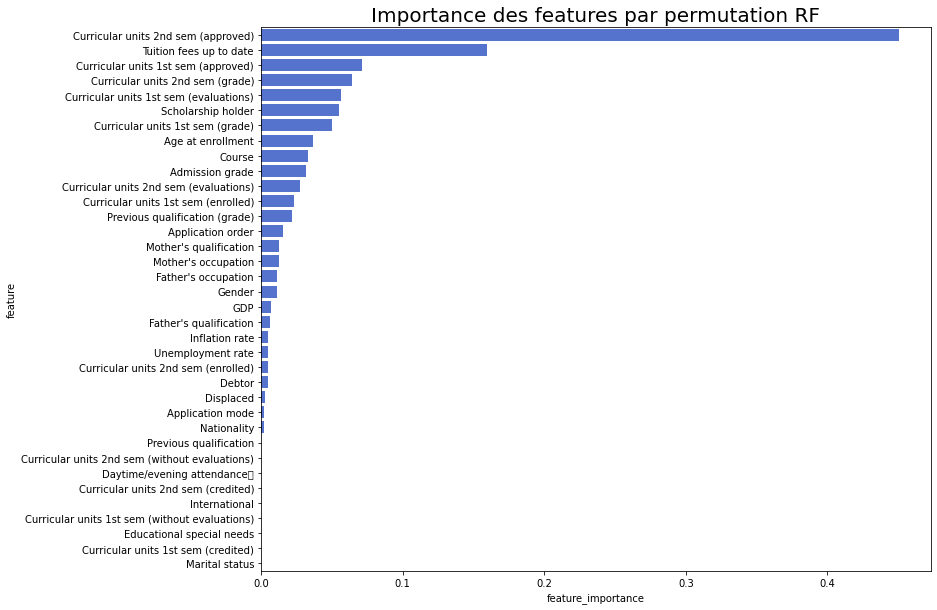

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from matplotlib import pyplot

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    fig, ax = pyplot.subplots(figsize=(12,10))
    sns.barplot(ax=ax,x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
    
forest =RandomForestClassifier(n_estimators=400,criterion = "entropy",n_jobs=-1,bootstrap=True)
forest.fit(X_train, y_train)

perm_imp_rfpimp = permutation_importances(forest,X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

var_imp_plot(perm_imp_rfpimp, 'Importance des features par permutation RF')

#### On affiche les variables les plus importantes pour ce problème de classification.

#### On observe que des  variables ont une importance nulle. Ici on utilise la méthode permutation du feature_importance. D'après la littérature c'est une méthode robuste en général pour comprendre l'importance des features.

#### Faire attention ici entre les liens entre les variables, de plus comme la classe graduate est sur représenté on imagine que l'importance des variables est influencé aussi par cette classe.

#### On peut éventuellement faire une sélection de feature à partir de ces résultats.

In [ ]:
# colums_drop=list(perm_imp_rfpimp[perm_imp_rfpimp["feature_importance"]==0]["feature"])

# X_train.drop(colums_drop,axis=1,inplace=True)
# X_test.drop(colums_drop,axis=1,inplace=True)

## 4) Premiers modèles

#### On se concentre sur des modèles de type boosting qui semble etre les plus efficace dans les problèmes de classifications avec des classes déséquilibrées (et après des test c'était effectivement le cas).

### RandomForest

Le score F_1 pour la classe Dropout est de  0.797
Le score F_1 pour la classe Enrolled est de  0.367
Le score F_1 pour la classe Graduate est de  0.837

Le score F_1 global (en prenant en compte la taille des classes) est de  0.734

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [1. 1. 1.]
Le score F_1 global sur l'ensemble d'apprentissage : 1.0

La matrice de confusion : 



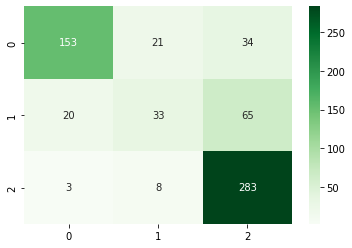

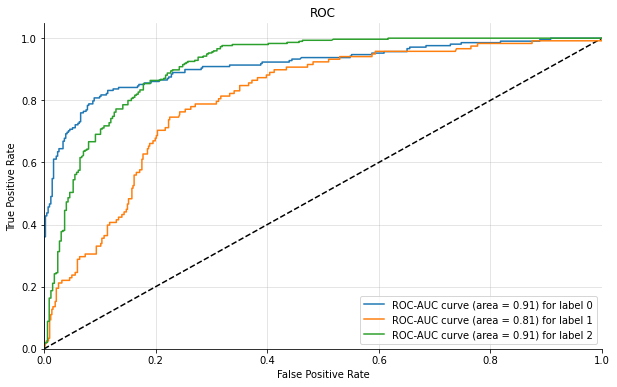

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfB = RandomForestClassifier(n_estimators=400)#On crée notre RandomForest
rfB.fit(X_train,y_train)#On la fit à nos données
rfB_pred =rfB.predict(X_test)# On prédit nos données

score_f1(y_test,rfB_pred) #Score
sur_apprentissage(y_train,rfB,X_train) #Overfitting
matrice_conf(y_test,rfB_pred) #Matrice de confusion

plot_multiclass_roc(RandomForestClassifier(n_estimators=400), X_test, y_test,3,X_train,y_train)

#### On obtient un score F_1 Global encourageant pour un premier modèle. Mais on remarque les difficultées d'apprentissage des classes Dropout et Enrolled (surtout Enrolled). On le voit bien aussi sur la courbe ROC-AUC. On remarque aussi de l'overfitting qui est classique avec ce genre de modèle.

### Gradient Boosting

Le score F_1 pour la classe Dropout est de  0.789
Le score F_1 pour la classe Enrolled est de  0.418
Le score F_1 pour la classe Graduate est de  0.829

Le score F_1 global (en prenant en compte la taille des classes) est de  0.737

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [0.99 0.98 0.99]
Le score F_1 global sur l'ensemble d'apprentissage : 0.99

La matrice de confusion : 



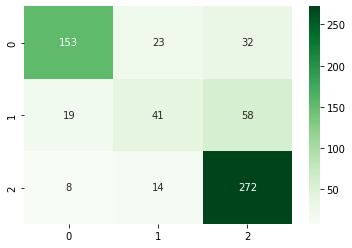

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier( 
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                     eval_metric='mlogloss', 
                      n_estimators=400, 
                      reg_alpha = 0.1,
                      max_depth=12, gamma=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score_f1(y_test,y_pred) #Score
sur_apprentissage(y_train,model,X_train) #Overfitting
matrice_conf(y_test,y_pred) #Matrice de confusion

#### On utilise le package XgBoost qui propose une descende de gradient optimisé. On observe des résultats similaire à la RandomForest. On pourrait tuner le modèle XGBoost qui peut etre sensible à certains paramètres. On ne peut afficher la courbe ROC-AUC car le modèle ne fait pas partie de sklearn.

#### On obtient des bons modèles pour la prédiction de la classe Graduate, mais des modèles moins perfomants pour les autres classes sous représentées. Essayons d'améliorer cela. 

## 5) Optimisation des modèles.

#### Pour améliorer la prédiction des classes sous représentées, une bonne méthode d'après la littérature est l'utilisation de Oversampling et Undersampling pour obtenir des classes équilibrées (surtout la méthode SMOTE).

#### On utilise le package Imblearn pour perfomer ces techniques.

In [ ]:
count = y.value_counts()
n_samples = int(count.median())

from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy


under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train,y_train,n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X_train,y_train)


over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

X_train,y_train=X_bal,y_bal

In [ ]:
y_train.value_counts(normalize=True)

0    0.333333
1    0.333333
2    0.333333
Name: Target, dtype: float64

#### Après l'application d'oversampling et Undersampling on obtient des classes équilbrées.

#### Pour augmenter la robustesse et éviter l'overfitting de nos modèles, on décide d'entrainer 4 modèles et d'utiliser un voting classifier. 

### RandomForest

Le score F_1 pour la classe Dropout est de  0.789
Le score F_1 pour la classe Enrolled est de  0.473
Le score F_1 pour la classe Graduate est de  0.833

Le score F_1 global (en prenant en compte la taille des classes) est de  0.75

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [1. 1. 1.]
Le score F_1 global sur l'ensemble d'apprentissage : 1.0

La matrice de confusion : 



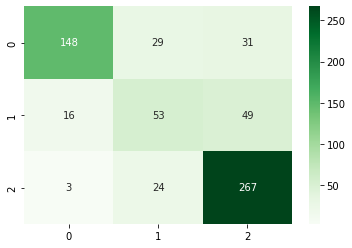

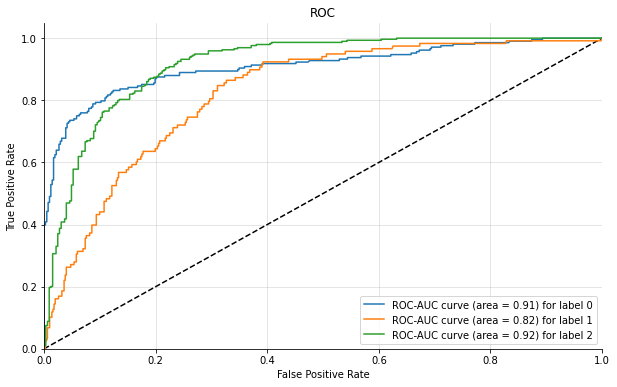

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfB = RandomForestClassifier(n_estimators=400)#On crée notre RandomForest
rfB.fit(X_train,y_train)#On la fit à nos données
rfB_pred =rfB.predict(X_test)# On prédit nos données

score_f1(y_test,rfB_pred) #Score
sur_apprentissage(y_train,rfB,X_train) #Overfitting
matrice_conf(y_test,rfB_pred) #Matrice de confusion

plot_multiclass_roc(RandomForestClassifier(n_estimators=400), X_test, y_test,3,X_train,y_train)

#### On obtient de meilleurs résultats sur les classes Enrolled / Graduate qui était le but souhaiter.

### ExtraTrees

Le score F_1 pour la classe Dropout est de  0.788
Le score F_1 pour la classe Enrolled est de  0.488
Le score F_1 pour la classe Graduate est de  0.838

Le score F_1 global (en prenant en compte la taille des classes) est de  0.755

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [1. 1. 1.]
Le score F_1 global sur l'ensemble d'apprentissage : 1.0

La matrice de confusion : 



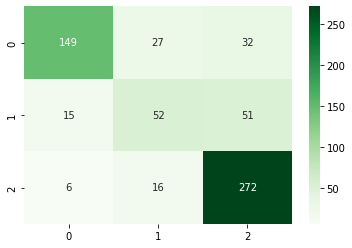

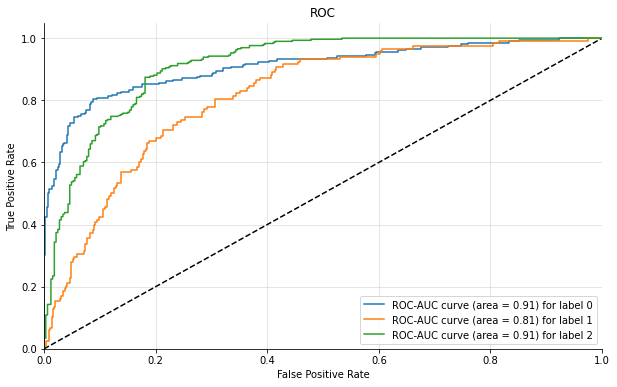

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=400)

etc.fit(X_train, y_train)

y_etc=etc.predict(X_test)
score_f1(y_test,y_etc)
sur_apprentissage(y_train,etc,X_train) #Overfitting
matrice_conf(y_test,y_etc) #Matrice de confusion

plot_multiclass_roc(ExtraTreesClassifier(n_estimators=400), X_test, y_test,3,X_train,y_train)

### Gradient Boosting

Le score F_1 pour la classe Dropout est de  0.785
Le score F_1 pour la classe Enrolled est de  0.505
Le score F_1 pour la classe Graduate est de  0.835

Le score F_1 global (en prenant en compte la taille des classes) est de  0.756

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [0.99 0.99 0.99]
Le score F_1 global sur l'ensemble d'apprentissage : 0.99

La matrice de confusion : 



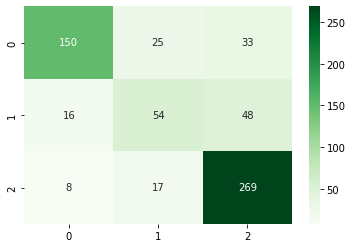

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier( 
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                     eval_metric='mlogloss', 
                      n_estimators=400, 
                      reg_alpha = 0.1,
                      max_depth=12, gamma=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score_f1(y_test,y_pred) #Score
sur_apprentissage(y_train,model,X_train) #Overfitting
matrice_conf(y_test,y_pred) #Matrice de confusion



### Régression Logistique
#### Pour éviter le sur-apprentissage des algos de type boosting on entraine aussi une régression logistique qui est une méthode linéaire.

Le score F_1 pour la classe Dropout est de  0.753
Le score F_1 pour la classe Enrolled est de  0.522
Le score F_1 pour la classe Graduate est de  0.822

Le score F_1 global (en prenant en compte la taille des classes) est de  0.742

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [0.78 0.68 0.79]
Le score F_1 global sur l'ensemble d'apprentissage : 0.75

La matrice de confusion : 



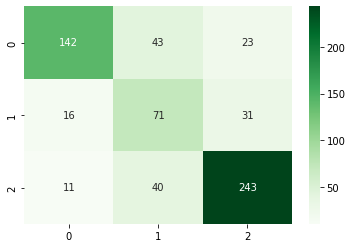

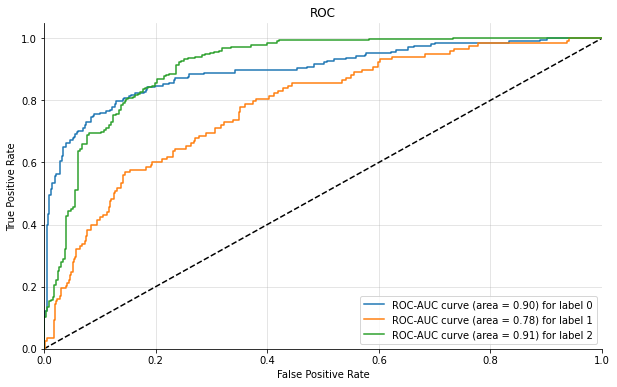

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import scipy as sc

pipeline=make_pipeline(LogisticRegression())

param_distributions = [{'logisticregression__C': sc.stats.expon(scale=100)}]
rs = RandomizedSearchCV(estimator=pipeline, param_distributions = param_distributions,
                        cv = 10, scoring = 'roc_auc_ovr_weighted', refit = True, n_jobs = 1,
                       random_state=1)

rs.fit(X_train, y_train)

y_pred=rs.predict(X_test)
score_f1(y_test,y_pred)
sur_apprentissage(y_train,rs,X_train) #Overfitting
matrice_conf(y_test,y_pred) #Matrice de confusion

plot_multiclass_roc(rs, X_test, y_test,3,X_train,y_train)

### Voting Classifier

Le score F_1 pour la classe Dropout est de  0.792
Le score F_1 pour la classe Enrolled est de  0.509
Le score F_1 pour la classe Graduate est de  0.838

Le score F_1 global (en prenant en compte la taille des classes) est de  0.76

Apprentissage sur l'ensemble train : 
Score F_1 par classe sur l'ensemble d'apprentissage :  [1. 1. 1.]
Le score F_1 global sur l'ensemble d'apprentissage : 1.0

La matrice de confusion : 



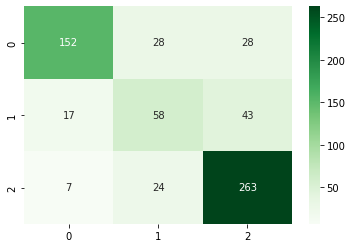

In [ ]:
from sklearn.ensemble import VotingClassifier

vcB = VotingClassifier( #On crée notre VotingClassifier
 estimators=[('rfB',rfB),("xgb",model),("rs",rs),("etc",etc)],
    voting='hard')

vcB.fit(X_train,y_train) #On entraine notre modèle

vcB_pred =vcB.predict(X_test)# On prédit nos données

score_f1(y_test,vcB_pred) #Score
sur_apprentissage(y_train,vcB,X_train) #Overfitting
matrice_conf(y_test,vcB_pred) #Matrice de confusion

#### On utilise le VotingClassifier avec nos 4 modèles ci-dessus.

## 5) Prédictions et Conclusion

#### On remarque que le score F_1 de notre votingClassifier varie de 0.75 à 0.80. On voit que notre modèle ne fait pas d'overfitting. Pour augmenter ce score on pourrait optmimiser les paramètres de certains modèles ou faire un meilleur feature engineering (sélection de variable, création ou ajout de variable).

#### Pour conclure, dans ce projet nous avions un problème de classifications avec des classes déséquilibrées. Sans trop de feature engineering on obtient des score corrects grace à la bonne prédiction de la classe majoritaire (Graduate). Le but d'un problème de classification est aussi la capacité à prédire toute les classes.

#### Grace à des techniques de sampling on à réussi l'augmentation de l'apprentissage de ses classes, couplé avec un Voting Classifier on obtient un modèle plus robuste pour la prédiction des 3 classes.